<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Demo_Map_Layers_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.system('pip install geopandas ;apt install libspatialindex-dev; pip install rtree; pip install osmnx')
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.ops import cascaded_union
from shapely.geometry import Point, Polygon

In [0]:
class Map:
  """Class docstrings go here."""

  def __init__(self, place_name):
    """
    Parameters
    ----------
    place_name : str 
      name of location. Excample: 'Fatih, Istanbul, Turkey'
      TODO: take in list and create composite map of multiple areas
    
    Attributes
    -------
    self.graph: networkx.classes.multidigraph.MultiDiGraph
        graph of streets (edges) and intersections (nodes) of the area
    self.area: geopandas.geodataframe.GeoDataFrame
        contains the POLYGON bounding the entire area
    self.building: geopandas.geodataframe.GeoDataFrame
        contains the POLYGONS bounding the buildings in the area
    self.nodes_df: geopandas.geodataframe.GeoDataFrame
        contains the POINTS representing the intersections of streets in the area
    self.edges_df: geopandas.geodataframe.GeoDataFrame             
        contains the LINESTRINGS representing streets of the area
    """
    assert isinstance(place_name, str), "please input a place name in string. Ex: 'Fatih, Istanbul, Turkey'"
    self.place_name = place_name
    # get graph data
    self.graph = ox.graph_from_place(place_name)
    self.graph = nx.relabel.convert_node_labels_to_integers(self.graph)
    # get the bounding area
    self.area = ox.gdf_from_place(place_name, buffer_dist= 50)
    # get information of buildings
    self.buildings = ox.footprints_from_place(place_name)
    self.nodes_df, self.edges_df = ox.graph_to_gdfs(self.graph)

  def Visualize_map(self, grid_coordinates = True):
    """
    Parameters
    ----------
    grid_coordinates : Boolean 
      conditional check whether to add coordinates onto map

    Returns
    -------
    show map plot of area including streetmap, buildings, and building density heatmap
    """
    fig, ax = plt.subplots(figsize=(14, 9), dpi= 80)
    self.area.plot(ax=ax, facecolor='gray')
    self.edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
    self.nodes_df.plot(ax=ax, linewidth=5, facecolor='white')
    self.buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
    self.building_density.plot(ax=ax, column='building_counts', cmap='Blues')
    if grid_coordinates:
      x_ = [i[0] for i in self.grid_coordinates]
      y_ = [i[1] for i in self.grid_coordinates]
      plt.scatter(x_,y_, s=0.75)
    plt.tight_layout()
    plt.show()
  
  def Add_grid(self, horizontal_grid_points =100):
    """
    Parameters
    ----------
    horizontal_grid_points : int; Default = 100
      how many grid points on horizontal axis. Number of grid points on vertical axis 
      is calculated automatically to keep grid cells square.

    Attributes
    -------
    self.df_cells: geopandas.geodataframe.GeoDataFrame    
        contains the POLYGONS representing grid cells. This allows for the checking for
        the intersection between a street vector and a particular grid cell.
    self.grid_coordinates: list of tuples
        contains the lon-lat coordinates of grid cells' corners, used to construct POLYGONS
        of grid cells.
    """
    ## extract Shapely object retrieved from OSMnx
    a = self.area.geometry.values[0]

    ## horizontal = 100 grid points 
    dem = 100
    horizontals = np.linspace(a.bounds[0], a.bounds[2], dem) 
    ## vertical = n grid points to make each grid space approximately a nice square
    num = int((a.bounds[3]-a.bounds[1])/(a.bounds[2]-a.bounds[0])*dem)
    verticals = np.linspace(a.bounds[1], a.bounds[3], num) 

    ## create a meshgrid (n,100) points
    x_coordinates, y_coordinates = np.meshgrid(horizontals, verticals) 
    ## assert to make sure meshgrid works well
    assert x_coordinates.shape == y_coordinates.shape
    #print(f"{(num, dem)} grid points created")  ##(77, 100) grid points created
    #print("x_coordinates shape =", x_coordinates.shape) ## x_coordinates shape = (77, 100)
    #print("y_coordinates shape = ", y_coordinates.shape) ## y_coordinates shape =  (77, 100)

    ## create points from coordinates and union them into lines
    Points = [Point(xp, yp) for xp, yp in zip(x_coordinates.ravel(), y_coordinates.ravel())]
    Points = cascaded_union(Points)

    ## grid-map based on shape of Shapely object supplied
    self.geom = Points.intersection(a)
    self.grid_coordinates = sorted([(points.x, points.y) for points in self.geom.geoms])

    #### record grid cells positions
    ## list of unique x coordinates and y coordinates
    x_list = sorted(list(set([points.x  for points in self.geom.geoms])))
    y_list = sorted(list(set([points.y  for points in self.geom.geoms])))
    ## dictionary allows for getting x[i+1] for a given x[i] and y[i+1] for a given y[i]
    x_dict = {x_list[i]: x_list[i+1] for i in range(len(x_list)-1)}
    y_dict = {y_list[i]: y_list[i+1] for i in range(len(y_list)-1)}
    polygons = []
    for i in range(len(self.grid_coordinates)-1):
      if self.grid_coordinates[i][1] == max(y_list): continue
      if self.grid_coordinates[i][0] == max(x_list): continue
      ### create polygons of cells to be added onto map layer                       
      polygons.append(Polygon([(self.grid_coordinates[i][0], y_dict[self.grid_coordinates[i][1]]),
                                    self.grid_coordinates[i],  
                                   (x_dict[self.grid_coordinates[i][0]] ,self.grid_coordinates[i][1]), 
                                   (x_dict[self.grid_coordinates[i][0]], y_dict[self.grid_coordinates[i][1]])]))     
    self.df_cells = gpd.GeoDataFrame({'df_cells':np.arange(len(polygons)),'geometry':polygons})

  def MakeHeatmap_BuildingDensity(self):
    """
    Attributes
    -------
    self.building_density: geopandas.geodataframe.GeoDataFrame    
        contains the POLYGONS representing grid cells plus the sum total of number of buildings inside the cell.
        Plotting this will create a heatmap
    """
    res_union = gpd.overlay(self.df_cells, self.buildings[['geometry']], how='intersection')
    counts = res_union.groupby('df_cells').count().rename(columns={'geometry':'building_counts'})
    self.building_density = self.df_cells.merge(counts, left_on = 'df_cells', right_index=True, how='left')

## Getting map and adding grids

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


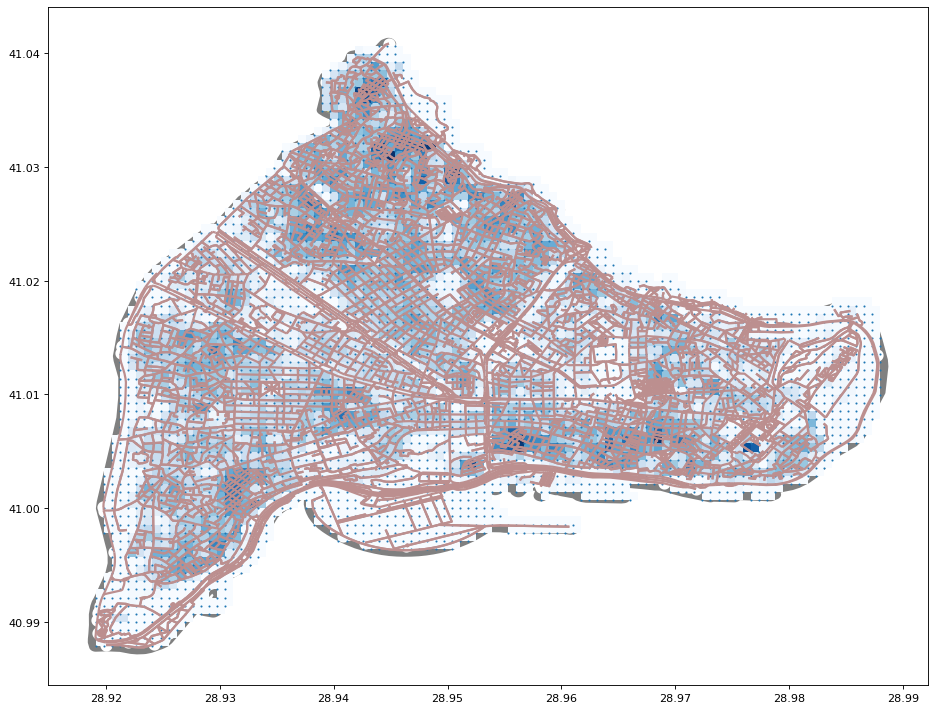

In [27]:
Map_1 = Map('Fatih, Istanbul, Turkey')
Map_1.Add_grid()
Map_1.MakeHeatmap_BuildingDensity()
Map_1.Visualize_map()

In [12]:
import folium
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location= (Map_1.area.centroid.y[0],Map_1.area.centroid.x[0]),
    zoom_start=30, control_scale=True)
# Convert points to GeoJSON
#points_gjson = folium.features.GeoJson(Map_1.nodes_df, name="Public transport stations")
# Add points to the map instance
#points_gjson.add_to(m)
# Create a layer control object and add it to our map instance
# Get x and y coordinates for each point
points = pd.DataFrame()
points["x"] = Map_1.buildings.geometry.centroid.x
points["y"] = Map_1.buildings.geometry.centroid.y

# Create a list of coordinate pairs
locations = list(zip(points["y"], points["x"]))
locations
HeatMap(locations).add_to(m)
folium.LayerControl().add_to(m)
m

In [8]:
Map_1.area.centroid.x[0]

28.971606426150792

In [0]:
# Get x and y coordinates for each point
points = pd.DataFrame()
points["x"] = Map_1.buildings.geometry.centroid.x
points["y"] = Map_1.buildings.geometry.centroid.y

# Create a list of coordinate pairs
locations = list(zip(points["y"], points["x"]))
locations

[(41.00926122917897, 28.922441837775196),
 (41.0179568, 28.923509600000003),
 (41.01927185257661, 28.924386132290795),
 (41.016761420349816, 28.922827112396035),
 (41.016056299999995, 28.922586299999995),
 (41.015541537803294, 28.92237591769532),
 (41.014235928372294, 28.922045037408417),
 (41.017457750760286, 28.92316022532599),
 (41.01398225398214, 28.922015128174223),
 (41.0127977, 28.922056399999995),
 (41.01103849999999, 28.922523999999992),
 (41.01048007593596, 28.922438482572126),
 (40.988618349999996, 28.920830849999998),
 (41.00801959999999, 28.922284599999994),
 (41.006715, 28.922045100000002),
 (41.006179144276985, 28.921863802550728),
 (41.005938799999996, 28.921845399999995),
 (41.00543302435831, 28.921758911028803),
 (41.00489477235591, 28.92165106196372),
 (41.00378312338205, 28.921445557620608),
 (41.00322405, 28.921326800000003),
 (41.002754028977336, 28.921181682450005),
 (41.002285553549996, 28.921048129036528),
 (41.0018087, 28.92090325),
 (41.001331, 28.920767),
 (

In [0]:
Map_1.building_density

df_cells  ... building_counts
0            0  ...             0.0
1            1  ...             0.0
2            2  ...             0.0
3            3  ...             0.0
4            4  ...             0.0
...        ...  ...             ...
3795      3795  ...             0.0
3796      3796  ...             0.0
3797      3797  ...             0.0
3798      3798  ...             0.0
3799      3799  ...             0.0

[3800 rows x 3 columns]

IndexError: ignored

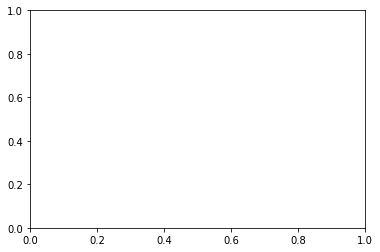

In [0]:
a = Map_1.building_density
a.building_counts.fillna(0,inplace=True)

fig, ax = plt.subplots()
sns.heatmap(a.building_counts, square=True)
fig.colorbar(im, ax=ax)
#a.building_counts.plot()

In [0]:
res_union = gpd.overlay(df_cells, Map_1.buildings[['geometry']], how='intersection')
res_union

df_cells                                           geometry
0            11  POLYGON ((28.91999 40.98898, 28.91999 40.98897...
1            28  POLYGON ((28.92001 40.98893, 28.92017 40.98893...
2            29  POLYGON ((28.92017 40.98893, 28.92001 40.98893...
3            14  POLYGON ((28.91957 40.99137, 28.91975 40.99135...
4            29  POLYGON ((28.92008 40.98941, 28.92006 40.98947...
...         ...                                                ...
47953      3749  POLYGON ((28.98604 41.01681, 28.98577 41.01681...
47954      3765  POLYGON ((28.98667 41.01608, 28.98679 41.01608...
47955      3766  POLYGON ((28.98679 41.01608, 28.98667 41.01608...
47956      3779  POLYGON ((28.98732 41.01334, 28.98736 41.01328...
47957      3779  POLYGON ((28.98729 41.01370, 28.98729 41.01364...

[47958 rows x 2 columns]

In [0]:
counts = res_union.groupby('df_cells').count().rename(columns={'geometry':'building_counts'})
df_cells.merge(counts, left_on = 'df_cells', right_index=True)

df_cells  ... building_counts
11          11  ...               1
14          14  ...               1
28          28  ...               1
29          29  ...               2
31          31  ...               1
...        ...  ...             ...
3748      3748  ...               1
3749      3749  ...               1
3765      3765  ...               1
3766      3766  ...               1
3779      3779  ...               2

[2974 rows x 3 columns]